In [1]:
import boto3
import sagemaker
from sagemaker import Model
import os
import json

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [2]:
sagemaker_session = sagemaker.Session()

role = sagemaker.get_execution_role()
print(f"SageMaker Role ARN: {role}")

SageMaker Role ARN: arn:aws:iam::796932308591:role/service-role/SageMaker-ExecutionRole-20250214T145019


In [3]:
# import packages
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, cross_val_score
# from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# set the aesthetic style of the plots
sns.set_style()

# filter warning messages
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.11/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [4]:
s3 = boto3.client('s3')

bucket = 'mitrailabs-personaclassification'
model_prefix = 'risk_prediction/data/'
response = s3.get_object(
    Bucket=bucket,
    Key=f"{model_prefix}clustered_data.csv"
)

X_processed = pd.read_csv(response['Body'])
X_processed_copy = X_processed.copy()


In [5]:
from sklearn.feature_selection import f_classif

X = X_processed.drop(columns=['Cluster', 'target_default'])
y = X_processed['Cluster']

print("Cluster in df_normalized:", 'Cluster' in X_processed.columns)  # Should be True
print("Cluster in X:", 'Cluster' in X.columns)  # Should be False



f_scores, p_values = f_classif(X, y)

# Create a DataFrame to display results
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'F-Score': f_scores,
    'P-Value': p_values
})

# Sort by F-Score (higher F-Score means more important)
feature_importance = feature_importance.sort_values(by='F-Score', ascending=False)

print(feature_importance)

Cluster in df_normalized: True
Cluster in X: False
                                           Feature       F-Score  P-Value
11                                facebook_profile           inf      0.0
67                             facebook_profile_sq           inf      0.0
42                      score_1_x_facebook_profile  3.720036e+04      0.0
43                      score_2_x_facebook_profile  2.626969e+04      0.0
21  external_data_provider_credit_checks_last_year  2.105914e+04      0.0
..                                             ...           ...      ...
56                                     score_1_bin           NaN      NaN
57                                     score_2_bin           NaN      NaN
58                       score_1_bin_x_score_2_bin           NaN      NaN
59                   score_1_bin_x_fraud_score_bin           NaN      NaN
60                   score_2_bin_x_fraud_score_bin           NaN      NaN

[68 rows x 3 columns]


In [6]:
# X = X.drop(columns=["score_2_bin_x_fraud_score_bin", 
#                 "score_1_bin_x_fraud_score_bin",
#                 "score_1_bin_x_score_2_bin",
#                 "score_2_bin",
#                 "score_1_bin"])
X.nunique().sort_values()

score_1_bin                          1
score_1_bin_x_score_2_bin            1
score_2_bin                          1
score_1_bin_x_fraud_score_bin        1
score_2_bin_x_fraud_score_bin        1
                                 ...  
score_4                          41741
reported_income_div_income       41741
score_6                          41741
avg_score_5_6                    41741
score_4_minus_score_3            41741
Length: 68, dtype: int64

In [7]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41741 entries, 0 to 41740
Data columns (total 68 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   score_1                                          41741 non-null  int64  
 1   score_2                                          41741 non-null  int64  
 2   score_3                                          41741 non-null  float64
 3   score_4                                          41741 non-null  float64
 4   score_5                                          41741 non-null  float64
 5   score_6                                          41741 non-null  float64
 6   risk_rate                                        41741 non-null  float64
 7   last_amount_borrowed                             41741 non-null  float64
 8   last_borrowed_in_months                          41741 non-null  float64
 9   credit_limit                

In [8]:

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, stratify=y, test_size=0.3)
print(len(X_train), len(X_test))
print("NaN in X_train:", X_train.isna().sum().sum())
print("NaN in y_train:", y_train.isna().sum())
print("Infinite values in X:", np.isinf(y_train.values).sum())

29218 12523
NaN in X_train: 0
NaN in y_train: 0
Infinite values in X: 0


In [9]:
X_train.columns

Index(['score_1', 'score_2', 'score_3', 'score_4', 'score_5', 'score_6',
       'risk_rate', 'last_amount_borrowed', 'last_borrowed_in_months',
       'credit_limit', 'income', 'facebook_profile', 'state', 'real_state',
       'ok_since', 'n_bankruptcies', 'n_defaulted_loans', 'n_accounts',
       'n_issues', 'application_time_in_funnel',
       'external_data_provider_credit_checks_last_month',
       'external_data_provider_credit_checks_last_year',
       'external_data_provider_email_seen_before',
       'external_data_provider_fraud_score', 'reported_income',
       'shipping_state', 'score_4_minus_score_3', 'avg_score_5_6',
       'debt_to_income', 'credit_utilization', 'default_rate',
       'reported_income_div_income', 'fraud_score_bin', 'credit_available',
       'income_per_account', 'loan_amount_to_income',
       'n_accounts_to_credit_limit', 'debt_to_income_x_default_rate',
       'credit_utilization_x_fraud_score', 'income_sq',
       'last_amount_borrowed_sq', 'score_1_

In [10]:
# scaler = MinMaxScaler().fit(X_train)
# X_train = scaler.transform(X_train)

# resample
# rus = RandomUnderSampler()
# X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

# from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance clusters
# smote = SMOTE(sampling_strategy='auto', random_state=42)
# X_train_rus, y_train_rus = smote.fit_resample(X_train, y_train)

X_train_rus, y_train_rus = (X_train, y_train)

# Check new cluster distribution
# print(pd.Series(y_train_rus).value_counts())

# print(X_train_rus)


In [11]:
# define the function val_model
def val_model(X, y, clf, show=True):
    """
    Apply cross-validation on the training set.

    # Arguments
        X: DataFrame containing the independent variables.
        y: Series containing the target vector.
        clf: Scikit-learn estimator instance.
        
    # Returns
        float, mean value of the cross-validation scores.
    """   
    X = np.array(X)
    y = np.array(y)

    pipeline = make_pipeline(MinMaxScaler(), clf)
    scores = cross_val_score(pipeline, X, y, scoring='recall')

    if show == True:
        print(f'Recall: {scores.mean()}, {scores.std()}')
    
    return scores.mean()

       score_1  score_2  score_3     score_4   score_5     score_6  risk_rate  \
33493        0        2    320.0   97.912991  0.956521  105.066733       0.30   
40992        4       12    310.0  100.129852  0.295036  104.508797       0.52   
15053        3        9    340.0  107.506312  0.072266   98.490385       0.30   
4181         3       26    430.0  100.861250  0.846504   97.995556       0.32   
26420        3        9    430.0   96.462426  0.204137   98.172248       0.23   
35227        2       20    450.0   99.255945  0.550011  113.621721       0.27   
40056        0       11    500.0  100.696629  0.290125  112.593483       0.21   
3911         1       27    600.0   96.770374  0.392009   97.679198       0.33   
18342        1        7    310.0   98.897200  0.716072   94.781603       0.40   
38136        2       14    240.0   99.066543  0.224149   84.422232       0.35   

       last_amount_borrowed  last_borrowed_in_months  credit_limit  ...  \
33493                  0.00      

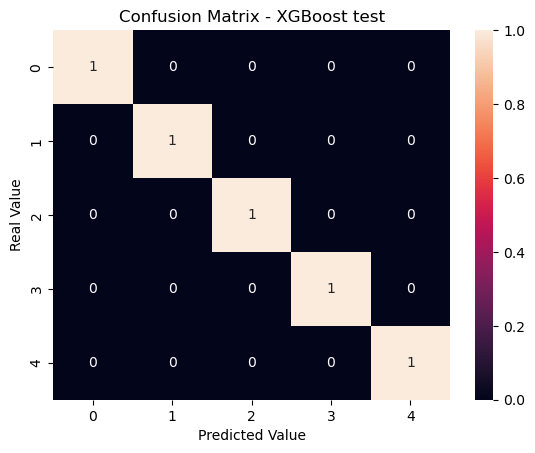

AUC Score: 1.0


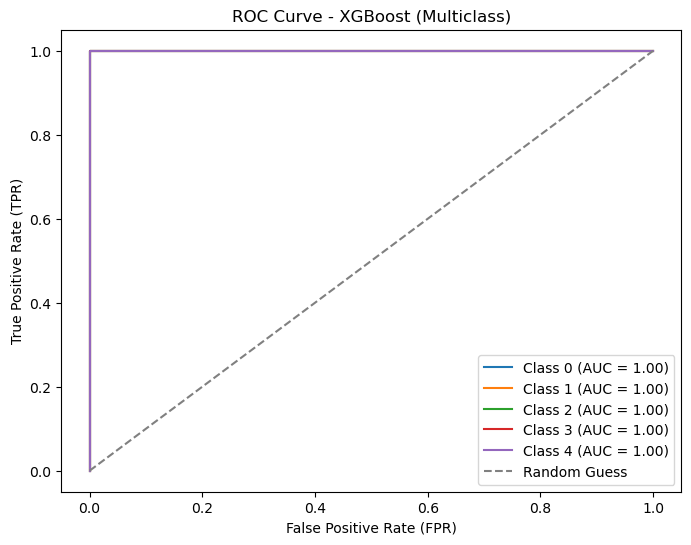

In [12]:
# final XGBoost model
xgb = XGBClassifier(
    max_depth=5, 
    learning_rate=0.01,  
    n_estimators=200, 
    gamma=1,  
    min_child_weight=6,  
    # subsample=0.8,  
    # colsample_bytree=0.8,  
    # reg_lambda=1,  
    # reg_alpha=0.1
)

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
# xgb = RandomForestClassifier(
#     n_estimators=200,  # Number of trees in the forest
#     max_depth=8,        # Maximum depth of the trees
#     #... other hyperparameters (e.g., min_samples_split, min_samples_leaf, etc.)...
#     random_state=42,     # For reproducibility
# )

# xgb = AdaBoostClassifier(n_estimators=100, learning_rate=0.01, algorithm='SAMME', random_state=42)  # Adjust parameters
xgb.fit(X_train_rus, y_train_rus)
# prediction
# scaler = MinMaxScaler().fit(X_test)
X_test_xgb = X_test #scaler.transform(X_test)
print(X_test_xgb.head(10))
y_pred_xgb = xgb.predict(X_test_xgb)

# classification report
print(classification_report(y_test, y_pred_xgb))

# confusion matrix
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, y_pred_xgb, normalize='true'), annot=True, ax=ax)
ax.set_title('Confusion Matrix - XGBoost test')
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Real Value')

plt.show()





from sklearn.preprocessing import label_binarize
y_pred_xgb = xgb.predict_proba(X_test_xgb)
n_classes = len(np.unique(y_test))
y_test_binarized = label_binarize(y_test, classes=np.arange(n_classes))

auc_score = roc_auc_score(y_test_binarized, y_pred_xgb)
print("AUC Score:", auc_score)

# Plot ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_xgb[:, i])
    roc_auc[i] = roc_auc_score(y_test_binarized[:, i], y_pred_xgb[:, i])

# Plot ROC curves
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve - XGBoost (Multiclass)')
plt.legend()
plt.show()

In [13]:
# import joblib

# xgb_model_path = 'saved/xgb_model.joblib'   
# joblib.dump(xgb, xgb_model_path)

# target_bucket = 'mitrailabs-personaclassification'
# target_prefix = 'risk_prediction/models'
# model_path = f'{target_prefix}/xgb_model.joblib'
# s3.upload_file(
#     xgb_model_path,
#     target_bucket,
#     model_path
# )
xgb_model_path = 'saved/xgb_model.json'  # Use .json for XGBoost's native format
xgb.save_model(xgb_model_path)  # Save in XGBoost's format

target_bucket = 'mitrailabs-personaclassification'
target_prefix = 'risk_prediction/models'
model_path = f'{target_prefix}/xgb_model.json'

s3.upload_file(
    xgb_model_path,
    target_bucket,
    model_path
)